# Dr D's guide to Spatial Interaction Modelling - Part 1: The Unconstrained (Total Constrained) Model


We are going to assume that you are familiar with python and anaconda. If not please see the first set of practicals. 

We should already have the Urbsim environment installed and we will proceed on the basis that we are using this kernel. As such, all packages that are required should already be installed and we can simply import all the packages that we may need.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

## Setting up some spatial data

AS the name suggests, to run a spatial model you are going to need some spatial data and some data on interactions (flows). Let's start with some spatial data.

In [2]:
#Fetch a GeoJson of some district-level boundaries from the ONS Geoportal. First add the URL to an object
url = "http://geoportal.statistics.gov.uk/datasets/8edafbe3276d4b56aec60991cbddda50_2.geojson"
EW = gpd.read_file(url)

Check to make sure the boundaries have downloaded OK...

<AxesSubplot:>

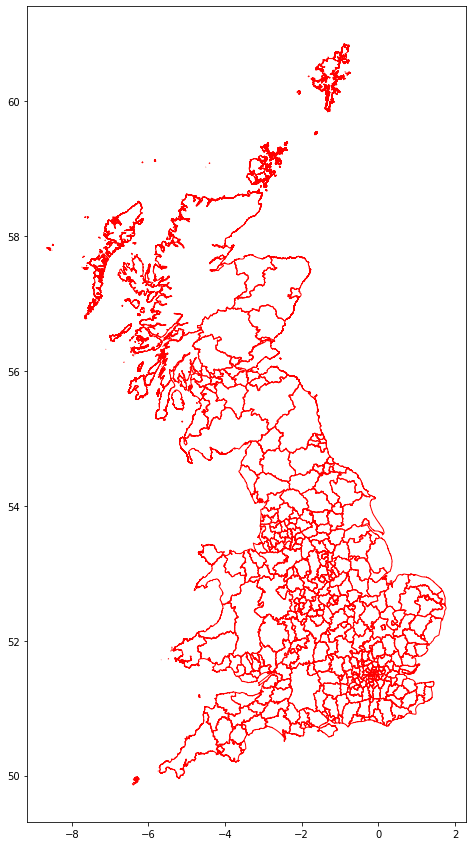

In [3]:
EW.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [4]:
EW.head(10)

,objectid,lad15cd,lad15nm,lad15nmw,st_areashape,st_lengthshape,geometry
0,1,E06000001,Hartlepool,,9.844169e+07,65270.302085,"POLYGON ((-1.26846 54.72612, -1.26858 54.72614..."
1,2,E06000002,Middlesbrough,,5.455358e+07,41055.846979,"POLYGON ((-1.25112 54.59153, -1.25173 54.59144..."
2,3,E06000003,Redcar and Cleveland,,2.538909e+08,101208.779781,"POLYGON ((-1.13633 54.64504, -1.13654 54.64510..."
3,4,E06000004,Stockton-on-Tees,,2.097308e+08,108085.159612,"POLYGON ((-1.31729 54.64480, -1.31756 54.64499..."
4,5,E06000005,Darlington,,1.974757e+08,107206.323036,"POLYGON ((-1.63768 54.61714, -1.63800 54.61720..."
5,6,E06000006,Halton,,9.032151e+07,60716.864614,"POLYGON ((-2.73037 53.39989, -2.73067 53.39994..."
6,7,E06000007,Warrington,,1.823836e+08,84154.518583,"POLYGON ((-2.49407 53.48010, -2.49410 53.48012..."
7,8,E06000008,Blackburn with Darwen,,1.370221e+08,65284.958201,"POLYGON ((-2.46850 53.78164, -2.46884 53.78175..."
8,9,E06000009,Blackpool,,4.315077e+07,36304.948644,"POLYGON ((-3.02048 53.85938, -3.02057 53.85940..."
9,10,E06000010,"Kingston upon Hull, City of",,8.149751e+07,45997.483017,"POLYGON ((-0.31613 53.81327, -0.31885 53.81288..."


For the time being lets extract London

In [5]:
London = EW[EW.lad15cd.str.contains("E09")]

<AxesSubplot:>

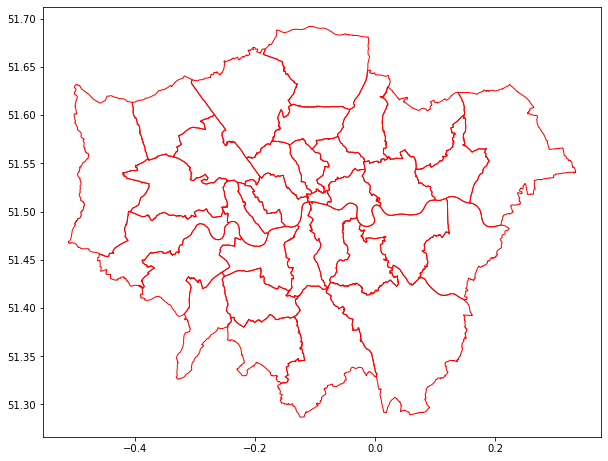

In [6]:
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [7]:
#look under the bonnet
London.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
London.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 293 to 325
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   objectid        33 non-null     int64   
 1   lad15cd         33 non-null     object  
 2   lad15nm         33 non-null     object  
 3   lad15nmw        33 non-null     object  
 4   st_areashape    33 non-null     float64 
 5   st_lengthshape  33 non-null     float64 
 6   geometry        33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 2.1+ KB


## Calculting a distance matrix

Now we have a nice clean set of London Boundaries, let's extract some spatial data. Of course, the important spatial data for spatial interaction models relates to the cost of interaction between places and this is very frequently represented through distance...

If you look at the crs above, the boundaries are not in the British National Grid Projection, as we can see that the CRS is WGS84 say that it is in longitude and latitude coordinates. We need to change this to the British National grid so our distances are in metres and not decimal decress, then we need to genereta a distance matrix.

C:\Users\phili\anaconda3\envs\urbansim\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

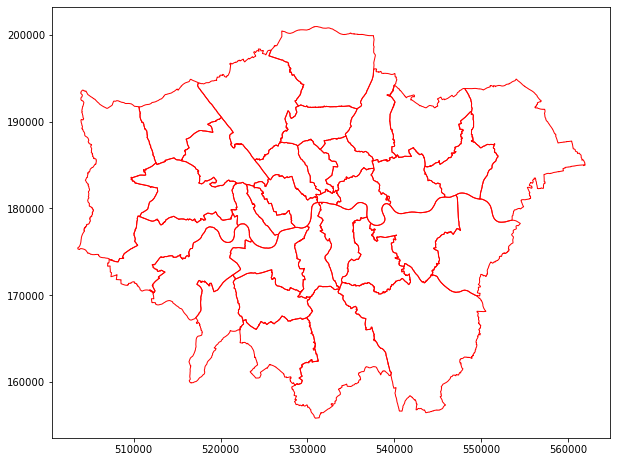

In [9]:
#transform london to BNG
London.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [10]:
#order it by borough code - *This step will be important later on*
London.sort_values(by=["lad15cd"], inplace = True)

#extract the centroids
London["Centroids"] = London.geometry.centroid

#drop any uncessary columns
LDN_cent = London.drop(columns = ["objectid", "lad15nm", "lad15nmw", "st_areashape", "st_lengthshape", "geometry"])

#extract the x and y coordinates
LDN_cent["x"] = LDN_cent["Centroids"].map(lambda p: p.x)
LDN_cent["y"] = LDN_cent["Centroids"].map(lambda p: p.y) 

#you can now drop the centroids
LDN_cent.drop(columns =[ "Centroids"], inplace = True)

<ipython-input-10-7dcec6f43237>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London.sort_values(by=["lad15cd"], inplace = True)
C:\Users\phili\anaconda3\envs\urbansim\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
#extract the distances for each possible pair
distances = []
for index1, row1 in LDN_cent.iterrows():
    for index2, row2 in LDN_cent.iterrows():
        #append the orig code, destination code and distance
        distances.append([row1["lad15cd"], row2["lad15cd"], 
                          ((float(row1["x"])-float(row2["x"]))**2 +(float(row1["y"])-float(row2["y"]))**2)**0.5])
        
#convert the resulting list into a dataframe        
distances = pd.DataFrame.from_records(distances, columns = ["Orig", "Dest", "Dist"])

#sort by origin code and then destination code
distances.sort_values(by=["Orig", "Dest"], inplace = True)

#check the results
distances

,Orig,Dest,Dist
0,E09000001,E09000001,0.000000
1,E09000001,E09000002,15995.228542
2,E09000001,E09000003,13935.670950
3,E09000001,E09000004,17359.908682
4,E09000001,E09000005,13119.797208
...,...,...,...
1084,E09000033,E09000029,16878.478719
1085,E09000033,E09000030,8735.485944
1086,E09000033,E09000031,13617.154003
1087,E09000033,E09000032,7067.552556


## Flow data

The data we are going to use to test our spatial interaction models is with commuting data from the 2001 England and Wales Census. In the Census, there is a question which asks your home address and another which asks the location of your usual place of work, as well as the method of transport that you mainly use to conduct your commute. From this, estaimtes of commuter flows by transportation type for the whole country can be generated.

In this exercise, to save time, I have already downloaded some sample data which records the place (Borough) or residence and place (Borough) of work for all people living in London at the time of the 2001 Census. Borough level is quite coarse but it will suffice for demonstration purposes. If you would like to download your own commuting or migration flow data, then you should visit the Census Support Flow Data Service callsed wicid - hhtps://wicid.ukdataservice.ac.uk/ - here you can download flows for a huge range of geographies from the 1981, 1991, 2001 and 2011 Censuses.

As well as flow data, I have also collected some additional data on income, the number of jobs in each borough in 2001 and the total population - we will uses these as destination atractiveness/mass term and origin emissinveness/mass term proxies in the models which follow.

In [12]:
#read in your London Commuting Data
cdata = pd.read_csv("https://www.dropbox.com/s/7c1fi1txbvhdqby/LondonCommuting2001.csv?raw=1")
#read in a lookup table for translating between old borough codes and new borough codes
CodeLookup = pd.read_csv("https://www.dropbox.com/s/h8mpvnepdkwa1ac/CodeLookup.csv?raw=1")
#read in some population and income data
popincome = pd.read_csv("https://www.dropbox.com/s/84z22a4wo3x2p86/popincome.csv?raw=1")

In [13]:
#add the new code to the origin old code and remove the uncessary columns
cdata = cdata.merge(CodeLookup, left_on = "OrigCode", right_on = "OldCode")
cdata.drop(columns = ["OldCode", "Label"], inplace = True)
cdata.rename(columns = {"NewCode": "OrigCodeNew"}, inplace = True)

#do the same with the destinations
cdata = cdata.merge(CodeLookup, left_on = "DestCode", right_on="OldCode")
cdata.drop(columns = ["OldCode", "Label"], inplace = True)
cdata.rename(columns = {"NewCode": "DestCodeNew"}, inplace = True)


In [14]:
#add the population income (here we will use the median income as it is a more reliable indicator and not 
#affected by skewness as much as average income might be)
popincome.drop(columns = ["label", "avg_income"], inplace = True)

#merge on the origins
cdata = cdata.merge(popincome, left_on = "OrigCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"vi1_origpop", "med_income": "vi2_origsal"}, inplace = True)

#do the same with the destination
cdata = cdata.merge(popincome, left_on = "DestCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"wj1_destpop", "med_income": "wj2_destsal"}, inplace = True)

In [15]:
#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the 
#distance data back in later
cdata.sort_values(by=["OrigCodeNew", "DestCodeNew"], inplace = True)

#reset the resulting index (important for later) when merging back together
cdata.reset_index(inplace=True)
cdata.drop(columns = ["index"], inplace=True)

To finish we need to add in our distance data that we generated earlier and create a new column of total flows that excludes the flows that occur within boroughs (we could keep the within-borough (intra-borough) flows in but they can cause problems so for new we will just exclude them).

In [16]:
#first we create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
def f(row):
    if row["OrigCode"] == row["DestCode"]:
        val = 0
    else: 
        val = row["Total"]
    return val
#apply this to create a new column
cdata["TotalNoIntra"] = cdata.apply(f, axis=1)

In [17]:
#set the number to a very small number
def r(row):
    if row["OrigCode"] == row["DestCode"]:
        val = 0.0000000001
    else: 
        val = 0
    return val
#apply this to a new column
cdata["offset"] = cdata.apply(r, axis=1)

In [18]:
#add the distance column into the dataframe
cdata = cdata.merge(distances, left_index=True, right_index=True )

#drop overlapping columns and rename
cdata.drop(columns = ["Orig_y", "Dest_y"], inplace=True)
cdata.rename(columns ={"Orig_x":"Orig", "Dest_x":"Dest"}, inplace=True)

Let's have a quick look at what the data now looks like

In [19]:
#look at the flows that originate from the city of London
cdata.head(33)

,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,Train,Bus,Taxi,...,Other,OrigCodeNew,DestCodeNew,vi1_origpop,vi2_origsal,wj1_destpop,wj2_destsal,TotalNoIntra,offset,Dist
0,City of London,00AA,City of London,00AA,2059,432,120,53,50,31,...,41,E09000001,E09000001,12000,38300,12000,38300,0,1.000000e-10,0.000000
1,City of London,00AA,Barking and Dagenham,00AB,6,0,3,3,0,0,...,0,E09000001,E09000002,12000,38300,56000,16200,6,0.000000e+00,15995.228542
2,City of London,00AA,Barnet,00AC,14,0,11,0,0,0,...,0,E09000001,E09000003,12000,38300,159000,18700,14,0.000000e+00,13935.670950
3,City of London,00AA,Bexley,00AD,0,0,0,0,0,0,...,0,E09000001,E09000004,12000,38300,112000,18300,0,0.000000e+00,17359.908682
4,City of London,00AA,Brent,00AE,16,0,10,0,3,0,...,0,E09000001,E09000005,12000,38300,127000,16500,16,0.000000e+00,13119.797208
5,City of London,00AA,Bromley,00AF,0,0,0,0,0,0,...,0,E09000001,E09000006,12000,38300,164000,19100,0,0.000000e+00,18740.822949
6,City of London,00AA,Camden,00AG,335,0,104,10,28,0,...,0,E09000001,E09000007,12000,38300,101000,19800,335,0.000000e+00,5742.818336
7,City of London,00AA,Croydon,00AH,3,0,0,0,3,0,...,0,E09000001,E09000008,12000,38300,153000,18300,3,0.000000e+00,17701.850875
8,City of London,00AA,Ealing,00AJ,9,0,6,3,0,0,...,0,E09000001,E09000009,12000,38300,141000,17500,9,0.000000e+00,16582.000060
9,City of London,00AA,Enfield,00AK,6,0,0,0,0,0,...,0,E09000001,E09000010,12000,38300,128000,17500,6,0.000000e+00,15197.557993


This is nice but to make this demonstration easier, let's just select a small subset of these flows (we can come back to the whole dataset later on...)

In [20]:
#we will just select the first 7 boroughs by code
to_match = ["00AA", "00AB", "00AC", "00AD", "00AE", "00AF", "00AG"]

#subset the data by the 7 sample boroughs
#first the origins
cdatasub = cdata[cdata["OrigCode"].isin(to_match)]
#then the destinations
cdatasub = cdatasub[cdata["DestCode"].isin(to_match)]

#now chop out the intra-borough flows
cdatasub = cdatasub[cdata["OrigCode"] != cdata["DestCode"]]

#we now want to re-order so that OrigCodeNEw, DestCodeNew and TotalNoIntra are the first three columns
beg = ["OrigCodeNew", "DestCodeNew", "TotalNoIntra"] 
cols = beg + [col for col in cdatasub.columns.tolist() if col not in beg]
#re index the columns
cdatasub = cdatasub.reindex(columns = cols)

<ipython-input-20-36878368c2de>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdatasub = cdatasub[cdata["DestCode"].isin(to_match)]
<ipython-input-20-36878368c2de>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdatasub = cdatasub[cdata["OrigCode"] != cdata["DestCode"]]


Now we can try plotting the flow lines

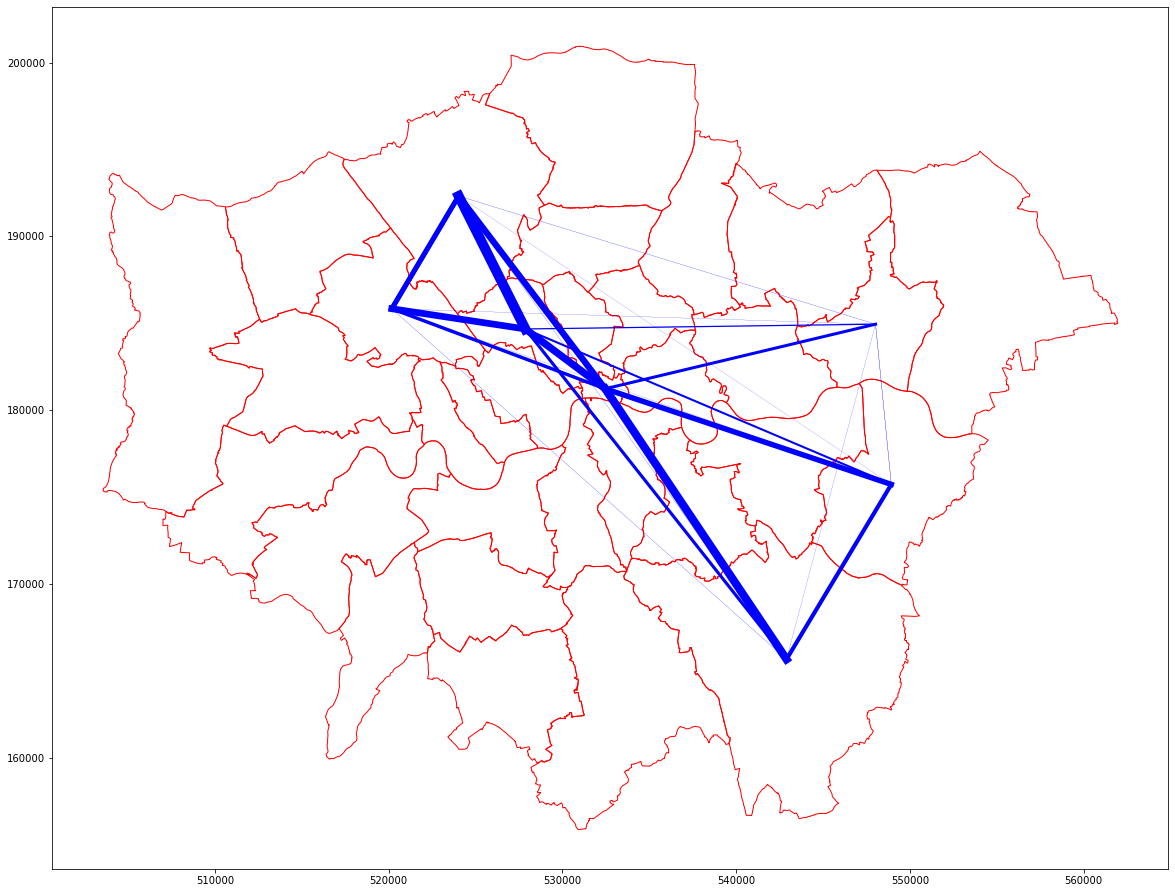

In [21]:
#plot the base map
London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")

#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the x coordinates
    x1 = [ LDN_cent[LDN_cent["lad15cd"] == row["OrigCodeNew"]]["x"], LDN_cent[LDN_cent["lad15cd"] == row["DestCodeNew"]]["x"]]
    #get the y coordinates
    y1 = [ LDN_cent[LDN_cent["lad15cd"] == row["OrigCodeNew"]]["y"], LDN_cent[LDN_cent["lad15cd"] == row["DestCodeNew"]]["y"]]
    #plot the line between the x and y coordinates with width reflecting the number of flows
    plt.plot(x1, y1, linewidth = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*10, color = "Blue")
    
#be careful when working with large amounts of data

Or, if you really want to be cool - on a leaflet map. See [here](https://python-visualization.github.io/folium/) for more details on this.

In [22]:
import folium

#set the base map to locate on London
my_map =folium.Map(location = [51.5, 0.1278], zoom_start = 10)

#transform to WGS84
London_WGS = London.to_crs("EPSG:4326")
London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)

#plot in leaflet
#This is done using the folium library
#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the first set of coordinates
    x1 = [London_WGS[London_WGS["lad15cd"]==row["OrigCodeNew"]]["x"].values[0],
       London_WGS[London_WGS["lad15cd"]==row["OrigCodeNew"]]["y"].values[0]]
    #get the second set of coordinates
    x2 = [ London_WGS[London_WGS["lad15cd"]==row["DestCodeNew"]]["x"].values[0],
           London_WGS[London_WGS["lad15cd"]==row["DestCodeNew"]]["y"].values[0]]
    #create a list of the coordinates
    coords = [x1, x2]
    #add a polyline with size reflective of the number of people
    folium.vector_layers.PolyLine(coords, weight = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*20, opacity = 0.5
                                 ).add_to(my_map)
                                
#plot the map                                
my_map

<ipython-input-22-c0032c5a20be>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
<ipython-input-22-c0032c5a20be>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)


In [23]:
import numpy as np
#now we can create a pivot table to trun paired list into a matrix, and compute the margin as well
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


Now that we have set everything up its

## Modellin' Time!

In explaining how to run and calibrate spatial interaction models in R, I will adopt the notation used by Taylor Oshan in his excellent primer for running spatial interaction models in Python. The paper is well worth a read and can be found [here](http://openjournals.wu.ac.at/region/paper_175/175.html)

Below is the classic multiplicate gravity model:

\begin{equation} \label{eq:1} \tag{1}
T_{ij} = k \frac{V_i^\mu  W_j^\alpha}{ d_{ij}^\beta}
\end{equation}

This gravity model can be written in the form more familiar from [Wilson's 1971 paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) 

\begin{equation} \label{eq:2} \tag{2}
T_{ij} = k V_i^\mu  W_j^\alpha  d_{ij}^{-\beta}
\end{equation}

<b>This model just says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversley proportional to the distance between them
    
As origin and destination masses increase, flows increase, but as distance icnreases, flows decrease, and vice versa</b>

- Where $T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the i and j are just generic indexes to allow us to refer to any cell in the matrix more generally.
- $V$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, $i$ - in our sample dataset, we have a vector of origin populations (which I have called vi1_origpop) and a vector of origin average salaries (which I have called vi2_origsal) in 2001
- $W$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of destination populations (which I have called wj1_destpop) and a vector of destination average salaries (which I have called wj2_destsal) in 2001
- $d$ is a matrix of costs relating to the flows between $i$ and $j$ - in our case the cost is distance and it is called ‘dist’ in our dataset.
- $k$, $μ$, $α$ and $β$ are all model parameters to be estimated

$k$ is a constant of proportionality and leads to this particular model being more accurately described as a ‘total constrained’ model as all flows estimated by the model will sum to any observed flow data used to calibrate the parameters, where:

\begin{equation} \label{eq:3} \tag{3}
k = \frac{T}{\sum_i \sum_j V_i^\mu  W_j^\alpha  d_{ij}^{-\beta}}
\end{equation}

and $T$ is the sum of our matrix of observed flows or:

\begin{equation} \label{eq:4} \tag{4}
T= \sum_i \sum_j T_{ij}
\end{equation}

In English, this is just the sum of all observed flows divided by the sum of all of the other elements in the model.


## Estimating Model Parameters

Now, it’s perfectly possible to produce some flow estimates by plugging some arbitrary or expected estimated values into our parameters. The parameters relate to the scaling effect / importance of the variables they are associated with. Most simply, where the effects of origin and destination attributes on flows scale in a linear fashion (i.e. for a 1 unit increase in, say, population at origin, we might expect a 1 unit increase in flows of people from that origin, or for a halving in average salary at destination, we might expect a halving of commuters), $\mu$ = 1 and $\alpha$ = 1. In Newton’s original gravity equation, $\beta$ = -2 where the influence of distance on flows follows a power law - i.e. for a 1 unit increase in distance, we have a $1^{-2}$ (1) unit decrease in flows, for a 2 unit increase in distance, we have $2^{-2}$ (0.25 or 1/4) of the flows, for a 3 unit increase, $3^{-2}$ (0.111) etc.

Let’s see if these parameters are a fair first guess (we’ll use the whole dataset in order to get a less messy picture)…


Text(0, 0.5, 'Total')

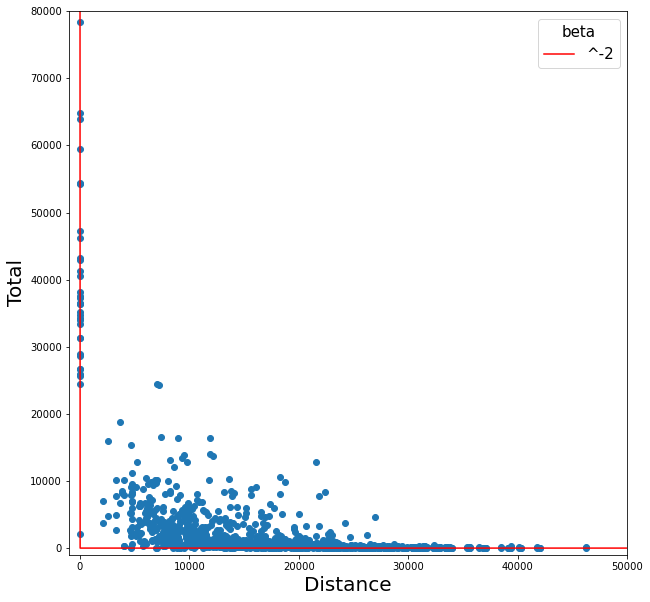

In [24]:
#first plot the commuter flows against distance and then fit a model line with a ^-2 parameter

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["Dist"], y=cdata["Total"])
#line plot
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "^-2")
#add a legend
ax.legend(title = "beta", fontsize = 15, title_fontsize=15)
#axis limits
ax.set_xlim([-1000,50000])
ax.set_ylim([-1000, 80000])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Total", fontsize = 20)

What about the origin and destination data

Text(0, 0.5, 'Total')

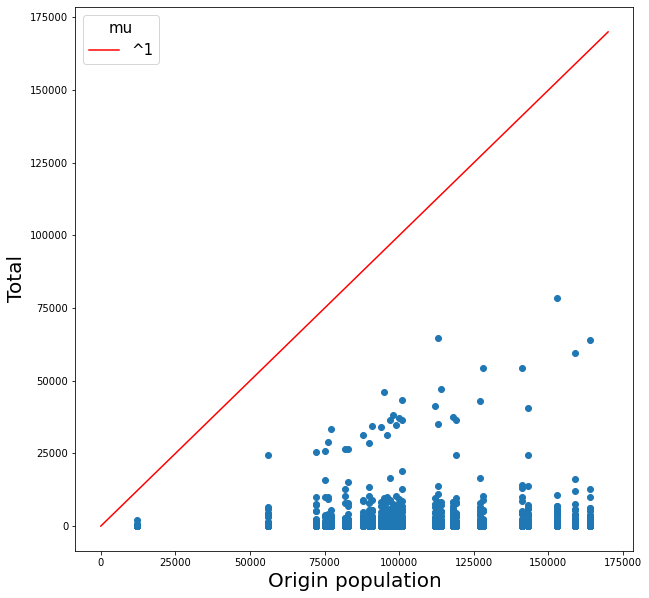

In [25]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["vi1_origpop"], y=cdata["Total"])
#line plot
line = np.arange(0.0002, 170_000, 0.1)
ax.plot(line, line**1, color ="r", label = "^1")
#add a legend
ax.legend( fontsize = 15, title = "mu", title_fontsize=15)
#axis labels
ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Total", fontsize = 20)


Text(0, 0.5, 'Total')

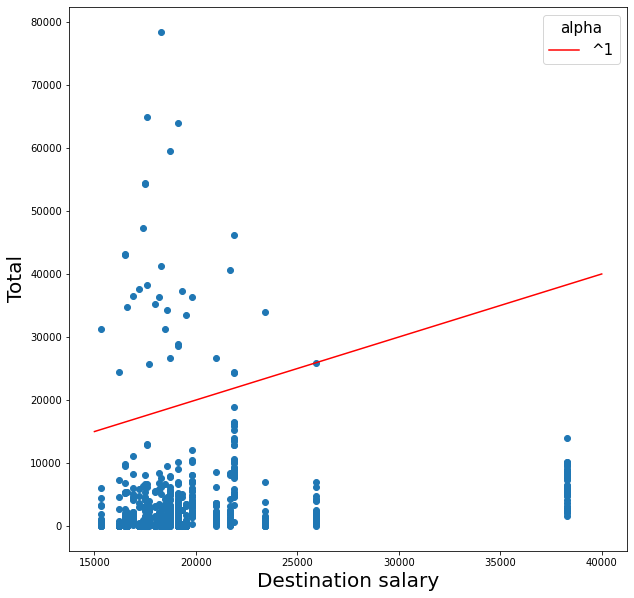

In [26]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["wj2_destsal"], y=cdata["Total"])
#line plot
line = np.arange(15_000, 40000, 0.1)
ax.plot(line, line**1, color ="r", label = "^1")
#add a legend
ax.legend( fontsize = 15, title = "alpha", title_fontsize=15)
#axis labels
ax.set_xlabel("Destination salary", fontsize = 20)
ax.set_ylabel("Total", fontsize = 20)


Okay, so it looks like we are not far off (well, destination salary doesn't look too promising as a predictor, but we'll see how we get on ...), so let's see what flow estimates with these starting parameters look like.

In [27]:
#set up some variables to hold our parameter values in:
mu = 1
alpha = 1
beta = -2
k = 1
T2 = sum(cdatasub["Total"])

Now we can create some flow estimates using equation 2 above... Begin by applying the parameters to the variables:

In [28]:
vi1_mu = cdatasub["vi1_origpop"]**mu
wj2_alpha = cdatasub["wj2_destsal"]**alpha
dist_beta = cdatasub["Dist"]**beta
T1 = vi1_mu*wj2_alpha*dist_beta
k = T2/sum(T1)

Then, just as in Equation 2 above, just multiply everything together to get your flow estimates.

In [29]:
#run the model and store of the new flow estimates in a new column
cdatasub["unconstrainedEst1"] = round(k*vi1_mu*wj2_alpha*dist_beta, 0)
#convert to integers
cdatasub["unconstrainedEst1"] = cdatasub["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst1"])

93802

We can turn this into a matrix to look at the predictors flows we have produced

In [30]:
cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,265.0,1902.0,190.0,428.0,435.0,1335.0,4555
Barnet,651.0,NaN,518.0,7344.0,453.0,6843.0,4995.0,20804
Bexley,3367.0,373.0,NaN,317.0,2475.0,675.0,2267.0,9474
Brent,422.0,6648.0,399.0,NaN,419.0,6627.0,4501.0,19016
Bromley,1063.0,458.0,3472.0,467.0,NaN,881.0,2849.0,9190
Camden,641.0,4105.0,562.0,4392.0,523.0,NaN,18684.0,28907
City of London,121.0,184.0,116.0,183.0,104.0,1148.0,NaN,1856
All,6265.0,12033.0,6969.0,12893.0,4402.0,16609.0,34631.0,93802


How do the flow estimates compare to the original flows?

In [31]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


## How good is my model?

So looking at the two matrices above you can see that in some cases theflow estimates aren't too bad (Barking and Dagenham to Barnet for example, but in others they are pretty rubish (Camden to the City of London?). Whilst it's OK to eyeball small flow matrics like this, when you have a much larger matrices we need another solution ...

### Testing the "Goodness-of-fit"

Yes, that’s what it’s called - I know, it doesn’t sound correct, but goodness-of-fit is the correct term for checking how well your model estimates match up with your observed flows.

So how do we do it?

Well… there are a number of ways but perhaps the two most common are to look at the coefficient of determination ($r^2$) or the Square Root of Mean Squared Error (RMSE). You’ve probably come across $r^2$ before if you have fitted a linear regression model, but you may not have come across RMSE. There are other methods and they all do more or less the same thing, which is essentially to compare the modelled estimates with the real data. $r^2$ is popular as it is quite intuitive and can be compared across models. RMSE is less intuitive, but some argue is better for comparing changes to the same model. Heres we’ll do both…

### R-Squared
 
$r^2$ is the square of the correlation coefficient, $r$

For our sample data, we can calculate this very easily using a little function.


In [32]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

CalcRSqaured(cdatasub["Total"], cdatasub["unconstrainedEst1"])

0.5032695879669563

Using this function we get a value of around 0.50, or around 50%. This tells us that our model accounts for about 50% of the variation of flows in the system. Not bad, but not brilliant either.

### Root Mean Squared Error (RMSE)

We can use a similar simple function to calcualte the RMSE for our data

In [33]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

CalcRMSE(cdatasub["Total"], cdatasub["unconstrainedEst1"])

2503.352

The figure that is produced by the RMSE calcaultion is far less intuitive than the $r^2$ and this is mainly because it very much depends on things like the units the data are in and the volume of the data. It can't be sued to compared different model run using different data sets. However, it is good for  assessing whether changes to the model result in improvements. The close to 0 the RMSE value, the better the model.

So how can we start to improve our fit...?

## Improving our model: 1 -  calibrating parameters

### (This bit might take a while but stick with it)

Now, the model we have run above is probably the most simple spatial interaction model we could have run and the results aren’t terrible, but they’re not great either.

One way that we can improve the fit of the model is by calibrating the parameters on the flow data that we have.

The traditional way that this has been done computationally is by using the goodness-of-fit statistics. If you have the requisite programming skills, you can write a computer algorithm that iteratively adjusts each parameter, runs the model, checks the goodness-of-fit and then starts all over again until the goodness-of-fit statistic is maximised.

This is partly why spatial interaction modelling was the preserve of specialists for so long as acquiring the requisite skills to write such computer programmes can be challenging!

However, since the early days of spatial interaction modelling, a number of useful developments have occurred…

The mathematically minded among you may have noticed that if you take the logarithms of both sides of Equation 2, you end up with the following equation:

\begin{equation} \label{eq:5} \tag{5}
\ln T_{ij} = k + \mu \ln V_i + \alpha \ln W_j - \beta \ln d_{ij}
\end{equation}

Those of you who have played around with regression models in teh past will realise that this is exactly that - a regression model.

And if you have played around with regression models you will be aware that there are various peices of software available to run regressions (such as Python) and calibrate the parameters for us, so we don't have to be expert programmers to do this - yay!

Now there are a couple of papers that are worth reading at this point. Perhaps the best is [Flowerdew and Aitkin (1982)](http://onlinelibrary.wiley.com/doi/10.1111/j.1467-9787.1982.tb00744.x/abstract), title “A METHOD OF FITTING THE GRAVITY MODEL BASED ON THE POISSON DISTRIBUTION”

One of the key points that Flowerdew and Aitkin make is that the model in equation 5 (known as a long-normal model) has various problems associated with it which means that the estimates produced might not be reliable. If you'd like to know about about there, read that paper (and also Wilson's 1971 paper), but at this point it is worth knowing that the way around many of these is to re-specify the model, not as a log-normal regression, but as a Poisson or negative binomial regression model.

## Poisson regression

The main theory (for non-experts like me anyway) behind the Poisson regression model is that the sorts of flows that spatial interaction models deal with (such as migration or commuting flows) relate to non-negative integer counts (you can’t have negative people moving between places and you can’t - normally, if they are alive - have fractions of people moving either).

As such, the continuous (normal) probabilty distributions which underpin standard regression models don’t hold. However, the discrtete probability distributions such as the Poisson distribution and the negative binomial distribution (of which the Poisson distribution is a special case - wikipedia it) do hold and so we can use these associations to model our flows.

At this point, it’s probably worth you looking at what a Poisson disribution looks like compared to a normal distribution, if you are not familiar.

Here’s a normal distribution:

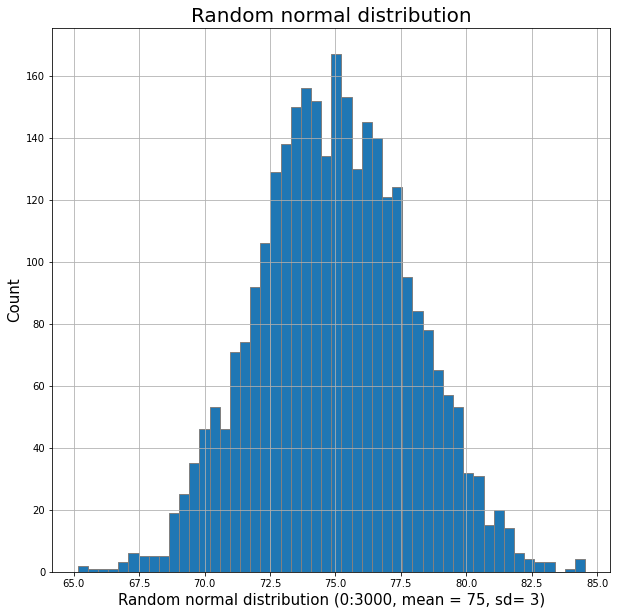

In [34]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.normal(loc = 75, scale= 3, size = 3000 ), bins = 50, edgecolor = "grey")
plt.xlabel("Random normal distribution (0:3000, mean = 75, sd= 3)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random normal distribution", fontsize = 20)
plt.grid(True)

Now here’s a Poisson distribution with the same mean:

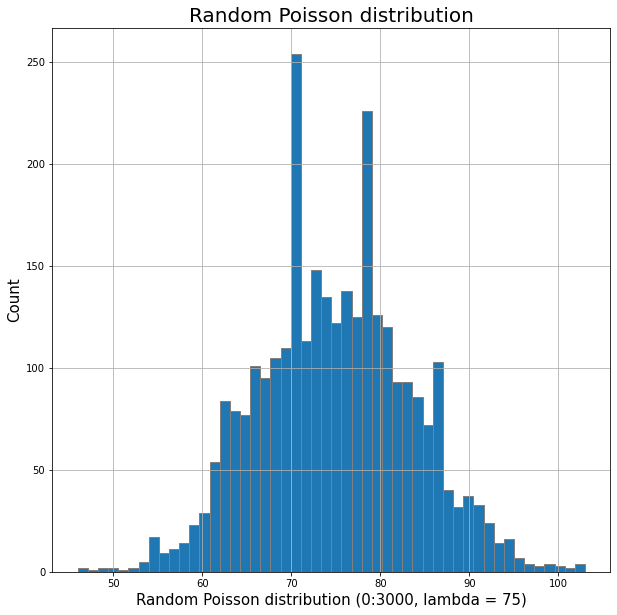

In [35]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.poisson(lam = 75, size = 3000 ), bins = 50, edgecolor = "grey")
plt.xlabel("Random Poisson distribution (0:3000, lambda = 75)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random Poisson distribution", fontsize = 20)
plt.grid(True)

Looks kind of similar doesn’t it! The thing with the Poisson distribution is, when the mean (λ - lambda) changes, so does the distribution. As the mean gets smaller (and this is often the case with flow data where small flows are very likely - have a look at the ‘Total’ column in your cdata dataframe, lots of small numbers aren’t there?) the distribution starts to look a lot more like a skewed or log-normal distrbution. They key thing is it’s not - it’s a Poisson distribution. Here’s a similar frequency distribution with a small mean:

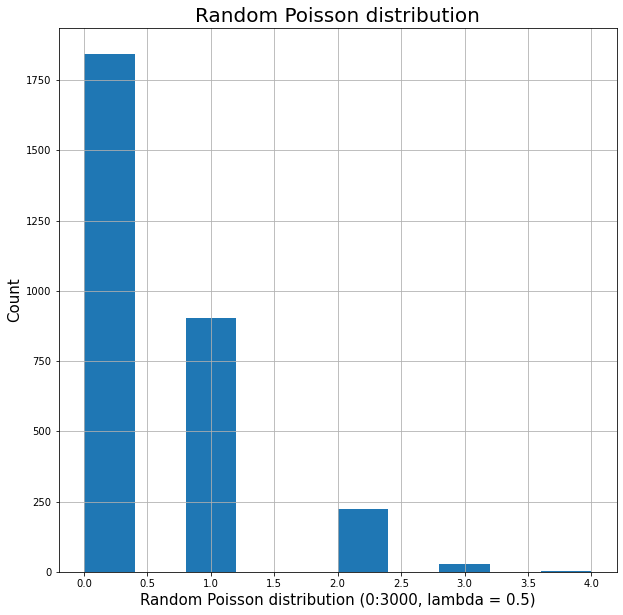

In [36]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.poisson(lam = 0.5, size = 3000))
plt.xlabel("Random Poisson distribution (0:3000, lambda = 0.5)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random Poisson distribution", fontsize = 20)
plt.grid(True)

As far as we’re concerned, what this means is that if we are interested in all flows between all origins and destinations in our system, these flows will have a mean value of $\lambda_{ij}$ and this will dictate the distribution. Here’s what the distrbution of our flows looks like:

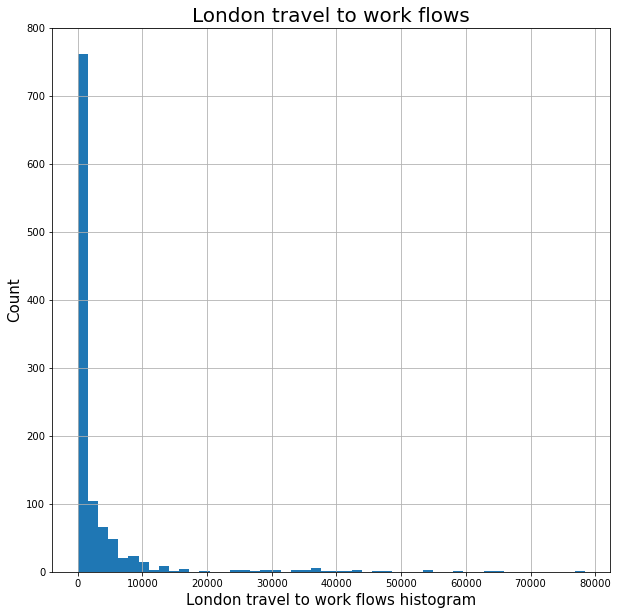

In [37]:
plt.subplots(figsize=(10,10))

plt.hist(cdata["Total"], histtype="stepfilled" , bins = 50)
plt.xlabel("London travel to work flows histogram", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("London travel to work flows", fontsize = 20)
plt.grid(True)

### Mmmm, Poissony!

So, what does all of this mean for our spatial interaction model?

Well the main thing it means is that Equation 5, for most sorts of spatial interaction models where we are modelling flows of people or whole things, is not correct.

By logging both sides of the equation in Equation 5, we are trying to get a situation where our Tij flows can be modelled by using the values of our other variables such as distance, by using a straight line a bit like this:

<AxesSubplot:xlabel='Dist', ylabel='Total'>

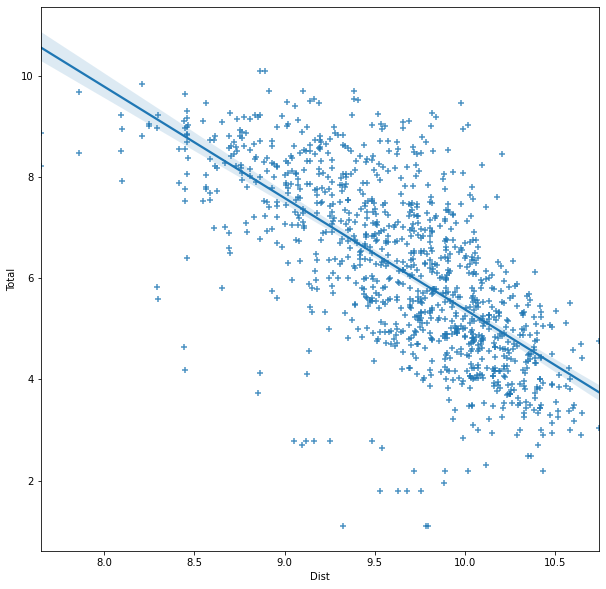

In [38]:
#subset the dataframe to the flows we want
cdata_flows = cdata[["Total", "Dist"]]
#remove all 0 values (logarithms can't deal with 0 values)
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["Dist"])
y = np.log(cdata_flows["Total"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))
#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)


If you compare this graph with the graph above (the first scatter plot we drew), it’s exactly the same data, but clearly by logging both the total and distance, we can get a bit closer to being able to fit a model estimate using a straight line.

What the Poisson distribution means is that the y variable in our model is not logged as in the graph above, but it can still be modelled using something like the blue line - I hope that sort of makes sense. If not, don’t worry, just take it from me that this is good news.

### The Poisson Regression Spatial Interaction Model

So, we can now re-specify Equation 5 as a Poisson Regression model. Instead of our independent variable being $\ln T_{ij}$ our dependent variable is now the mean of our Poisson distribution $\lambda_{ij}$ and the model becomes:

\begin{equation} \label{eq:6} \tag{6}
\lambda_{ij} = \exp (k + \mu \ln V_i + \alpha \ln W_j - \beta \ln d_{ij})
\end{equation}

What this model says is $\lambda_{ij}$ (our independent variable - the estaimte of $T_{ij}$) is <i>logarithmically linked </i> to (or modelled by) a linear combination of the logged independent variables in the model.

Now we have Equation 6 at our disposal, we can use a Poisson regression model to produce estimated of $k$, $\mu$, $\alpha$ and $\beta$ - or put another way, we can use the rgeression model to calibrate our parameters.

So, let's have a go at doing it!

It is very straightforward to run a Poisson regression model in Python using the `glm` function in the Statsmodel.api library. In practical terms, running a GLM model is no different to running a standard regression model using `lm`. If you want to find more details about this you can visit the statsmodel api documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM) and [here](https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html) or for more information about the Poission regression application you can read other articles on the internet such as this [medium article](https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958). If you delve far enough into the depths of what GLM does, you will find that the parameters are calibrated though an ‘iteratively re-weighted least squares’ algorithm. This algorithm does exaxtly the sort of job I described earlier, it fits lots of lines to the data, continually adjusting the parameters and then seeing if it can minimise the error between the observed and expected values useing some goodness-of-fit measure is maximised/minimised.

These sorts of algorithms have been around for years and are very well established so it makes sense to make use of them rather than trying to re-invent the wheel ourselves. So here we go…

In [39]:
import statsmodels.api as sm

#take the variables and produce logarithms of them
x_variables = ["vi1_origpop", "wj2_destsal", "Dist"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x])
    log_x_vars.append(f"log_{x}")

#extract our x values
x = cdatasub[log_x_vars]
#add a constant which will act as out intercept
x = sm.add_constant(x)
#extract the y value
y = cdatasub["Total"]

#run the regression
uncosim = sm.GLM(y, x, family=sm.families.Poisson()).fit()


It’s a simple as that - runs in a matter of milliseconds. You should be able to see how the `glm` code corresponds to Equation 6.

`Total` = $T_{ij}$ = $\lambda_{ij}$

`~` means ‘is modelled by’

`log(vi1_origpop)` = $\ln V_i$

`log(wj2_destsal)` = $\ln W_j$

`log(dist)` = $\ln d_{ij}$

`family=sm.families.Poisson()`means that we are using a Poisson regression model (the link is always log with a Poisson model) where the left-hand side of the model equation is logarithmically linked to the variables on the right-hand side.

So what comes out of the other end?

Well, we can use the `summary()` function to have a look at the model parameters:

In [40]:
#extract the summary of the constrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23200.
Date:                Wed, 06 Jan 2021   Deviance:                       46086.
Time:                        14:22:36   Pearson chi2:                 4.69e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -15.8084      0.177    -

We can see from the summary that the Poisson regression has calibrated all 4 parameters for us and these appear under the ‘estimate’ column:

$k$ (intercept) = -15.8084

$\mu$ = 1.7558

$\alpha$ = 1.6472

and $\beta$ = -1.4079

We can also see from the other outputs that all variables are highly significant (P>|z| < 0.01), with the z-scores revealing that distance has the model influence on the model (as we might have expected from the scatter plots we produced earlier which showed that distance had by far the strongers correlation with commuting flows).

These parameters are not too far away from our initial guesses of $\mu$ = 1, $\alpha$ = 1 and $\beta$ = -2, but how do the estimates compare?

One way to calculate the estimates is to plug all of the parameters back into Equation 6 like this:

In [41]:
#first assign the parameter values from the model to the appropriate variables
k = uncosim.params[0]
mu = uncosim.params[1]
alpha = uncosim.params[2]
beta = uncosim.params[3]

#now plug everything back into the Equation 6 model ... (be careful with the positive and negative signing of the 
#parameters as the beta parameter may not have been saved as a negative so will need to force negative)
cdatasub["unconstrainedEst2"] = np.exp(k + mu*cdatasub["log_vi1_origpop"] + alpha*cdatasub["log_wj2_destsal"] +
                                      beta*cdatasub["log_Dist"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction(x)
predictions_summary_frame = predictions.summary_frame()
cdatasub["fitted"] = predictions_summary_frame["mean"]

In [42]:
#round the numbers so that we don't get a half of a person
cdatasub["unconstrainedEst2"] = round(cdatasub["unconstrainedEst2"], 0)
#convert to integers
cdatasub["unconstrainedEst2"] = cdatasub["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst2"])

93803

In [43]:
#turn it into a little matrix and have a look at your handy work
cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,206.0,808.0,145.0,294.0,308.0,1264.0,3025
Barnet,1015.0,NaN,968.0,5683.0,919.0,6422.0,9587.0,24594
Bexley,2231.0,542.0,NaN,430.0,2099.0,869.0,3803.0,9974
Brent,591.0,4707.0,636.0,NaN,686.0,4957.0,7034.0,18611
Bromley,1480.0,937.0,3820.0,844.0,NaN,1567.0,6670.0,15318
Camden,623.0,2635.0,637.0,2455.0,630.0,NaN,15056.0,22036
City of London,20.0,32.0,22.0,28.0,22.0,121.0,NaN,245
All,5960.0,9059.0,6891.0,9585.0,4650.0,14244.0,43414.0,93803


In [44]:
#compare it to the actual flows
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


We can see here that some of the estimates have improved such as Barking and Dagenham to Barnet is now even closer and is within 10% of the actual flow, while the Barking and Dagenham to Bexley predicted flow has converged but is still far out.

Therefore the $1,000,000 question is - has calibrating the parameters improved the model...?

In [45]:
CalcRSqaured(cdatasub["Total"], cdatasub["unconstrainedEst2"])

0.6725599227081145

In [46]:
CalcRMSE(cdatasub["Total"], cdatasub["unconstrainedEst2"])

1892.615

## Yes indeedy do!!

The $r^2$ has improved from 0.50 to 0.67 and the RMSE has reduced from 2503.35 to 1892.62 so by calibrating our parameters using the Poisson Regression Model, we have markedly improved our model fit.

But we can do even better. We have just been playing with the unconstrained model, by adding constraints into the model we can both improve our fit further AND start to do cool things like estimate transport trip distributions from known information about people leaving an area, or estaimte the amount of money a shop is going to make from the available money that people in the surrounding area have to spend, or guess the number of migrants travelling between specific countries where we only know how many people in total leave one country and arrive in another.

We'll do all of this in part 2 of these sessions.


## Extension ideas for this session:

1. Have a play around with inputting different parameter values and see what happens to the flow estimates - for example, what happens if you change the frictional effect of distance by increasing and decreasing the negative value of the $\beta$ parameter? Try some values of -2,-3,-4. What do positive values do to the flows?


2. What happens to the flow estimates if you adjust the other parameters in the model or remove $k$?


3. Try running the model on the whole London system - although you may run into problems if you don’t remove the intra-borough flows. This is because for intra-flows, the distance value is 0 and you can’t take the log of 0. To fix this, you can either change all of the zero distance values to something very small (like 1 or 0.5) or, alternatively, remove all rows in the data where origin = destination with some code like this: `cdata2 = cdata[cdata["OrigCode"] != cdata["DestCode"]]`


4. What might you expect to happen to the flows of people between, say, Camden and Brent if all of a sudden loads of really well paid jobs appeared in Brent and the average salary doubled? How might this impact the other Boroughs in the system?


In [49]:
cdatasub.to_csv("Data/cdatasub1.csv")